# Desafio Civitas

Neste desafio, optei por uma abordagem de análise em python por ser a ferramenta que sou mais familiarizado.

## Acesso aos dados no BigQuery

In [17]:
#!pip install basedosdados # Instalando biblioteca da prefeitura para leitura de dados
# Sistema
import os
import dotenv
from pathlib import Path

# Banco de dados
import pandas as pd
import basedosdados as bd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Carregando o project id das variaveis de ambiente por se tratar de dados confidenciais -- ver .env.sample
dotenv.load_dotenv()
project_id = os.getenv('PROJECT_ID')

Aqui realizei o download dos dados.\
Defini uma condicional para não precisar acessar todas as vezes os servidores do Google Cloud, evitando gastos desnecessários. Ao rodar a célula pela primeira vez os arquivos são baixados e salvos na pasta 'data/', apartir daí o programa carrega eles localmente.\
Cabe ressaltar que aqui usei samples de 1 milhão de dados apenas para a análise, nos arquivos das queries SQL elas estão sem o LIMIT

In [19]:
# Definindo nomes dos arquivos
data_path = "data/"
cloned = "placas_clonadas"
file_name = "full_data"

# Definindo o path para arquivos locais
data_full_cache_path = Path(data_path).joinpath(f"{file_name}.csv")
data_cloned_cache_path = Path(data_path).joinpath(f"{cloned}.csv")

# Carregar localmente caso os arquivos existam em 'data/'
if data_full_cache_path.is_file() and data_cloned_cache_path.is_file():
    print("Carregando dos arquivos locais...")
    df = pd.read_csv(data_full_cache_path)
    cloned_df = pd.read_csv(data_cloned_cache_path)
    print("Dataframes carregados")

# Carregar pelo BigQuery caso não existam localmente
# Limitei os queries em 1 milhão de linhas para aumentar a velocidade do download
else:
    print("Carregando do Big Query...")
    # Query completa com as colunas utilidas
    query_full = """
    SELECT * EXCEPT(datahora_captura, camera_latitude, camera_longitude)
    FROM `rj-cetrio.desafio.readings_2024_06`
    LIMIT 1000000
    """

    # Query para possiveis placas clonadas
    query_cloned ="""
    WITH RadarDetections AS (
        SELECT
            datahora,
            placa,
            camera_numero,
            camera_latitude,
            camera_longitude
        FROM
            `rj-cetrio.desafio.readings_2024_06`
    )

    SELECT
    rd1.placa,
    rd2.placa,
    rd1.datahora,
    rd2.datahora,
    rd1.camera_numero,
    rd2.camera_numero,
    rd1.camera_latitude,
    rd2.camera_latitude,
    rd1.camera_longitude,
    rd2.camera_longitude,
    ABS(TIMESTAMP_DIFF(rd1.datahora, rd2.datahora, SECOND)) AS diff_seconds

    FROM
    RadarDetections rd1

    JOIN
    RadarDetections rd2

    ON rd1.placa = rd2.placa
    AND rd1.camera_numero <> rd2.camera_numero
    AND ABS(TIMESTAMP_DIFF(rd1.datahora, rd2.datahora, SECOND)) < 1800
    ORDER BY
    rd1.placa, rd1.datahora
    LIMIT 1000000
    """
    # Criando dataframe com ambas queries
    df = bd.read_sql(query=query_full, billing_project_id=project_id)
    cloned_df = bd.read_sql(query=query_cloned, billing_project_id=project_id)
    print("Dataframes carregados")

    # Salvando para não precisar realizar a query novamente no GBQ
    df.to_csv(path_or_buf= f"{data_path}{file_name}.csv")
    cloned_df.to_csv(path_or_buf=f"{data_path}{cloned}.csv")


Carregando dos arquivos locais...
Dataframes carregados


### Análises básicas dos dataframes

1. Dataframe contendo as colunas: 'datahora', 'placa', 'empresa', 'tipoveiculo', 'velocidade', 'camera_numero' para algumas análises envolvendo a velocidade e o horário registrado
2. Dataframe a partir Query SQL que identifique e retone possíveis placas clonadas -- Identifica placas que foram registradas em radares diferentes em um período menor do que 30 minutos

In [20]:
# Printando algumas informações importantes sobre os dataframes
print(f"""Dataframe completo:
Shape:{df.shape};
Colunas:{list(df.columns)}
Duplicatas:{df.duplicated().sum()}
Valores nulos:
{df.isna().sum()}
""")

print("_________________________________________________________________________________________________________________")

print(f"""\nDataframe placas clonadas:
Shape:{cloned_df.shape};
Colunas:{list(cloned_df.columns)}
Duplicatas:{cloned_df.duplicated().sum()}
Valores nulos:
{cloned_df.isna().sum()}
""")

# Remover coluna 'Unnamed 0' -- index duplicado
df.drop(columns='Unnamed: 0', inplace=True)
cloned_df.drop(columns='Unnamed: 0', inplace=True)

Dataframe completo:
Shape:(1000000, 7);
Colunas:['Unnamed: 0', 'datahora', 'placa', 'empresa', 'tipoveiculo', 'velocidade', 'camera_numero']
Duplicatas:0
Valores nulos:
Unnamed: 0       0
datahora         0
placa            0
empresa          0
tipoveiculo      0
velocidade       0
camera_numero    0
dtype: int64

_________________________________________________________________________________________________________________

Dataframe placas clonadas:
Shape:(1000000, 12);
Colunas:['Unnamed: 0', 'placa', 'placa_1', 'datahora', 'datahora_1', 'camera_numero', 'camera_numero_1', 'camera_latitude', 'camera_latitude_1', 'camera_longitude', 'camera_longitude_1', 'diff_seconds']
Duplicatas:0
Valores nulos:
Unnamed: 0            0
placa                 0
placa_1               0
datahora              0
datahora_1            0
camera_numero         0
camera_numero_1       0
camera_latitude       0
camera_latitude_1     0
camera_longitude      0
camera_longitude_1    0
diff_seconds          0
dt

## Análise exploratória

### Dataframe completo

In [21]:
# Checando primeiros dados do dataframe
df.head(5)

,datahora,placa,empresa,tipoveiculo,velocidade,camera_numero
0,2024-06-09 16:41:34+00:00,b'\xb3\xc8\xaf\xce\x89h\xe0=niD\x01\xd0w)7B',b'\x08\x91\x96{A?\xa4',b'\x03\x1c\xc0\x03~\x81m',34,b'\x00i*rt\xb1Y'
1,2024-06-09 21:26:17+00:00,b'\x1f\x88W\xb9\xdfF\xf1Qu\xbd\x80\xb5\x987g;\...,b'\x08\x91\x96{A?\xa4',b'\x03\x1c\xc0\x03~\x81m',36,b'\x00i*rt\xb1Y'
2,2024-06-10 09:04:07+00:00,b'+j\x88Us\xbdZ\x1b\xdb\x9f\xa0r\xd50\x15\xea\...,b'\x08\x91\x96{A?\xa4',b'\x03\x1c\xc0\x03~\x81m',39,b'\x00i*rt\xb1Y'
3,2024-06-06 10:15:35+00:00,b'\xe7\xa0X^\x85GE\xba\xfcu\xc0\xe6\xfa\xef\xd...,b'\x08\x91\x96{A?\xa4',b'\x03\x1c\xc0\x03~\x81m',32,b'\x00i*rt\xb1Y'
4,2024-06-09 19:28:44+00:00,b'7\xa9jk\x9a\xe2\xf8\xf3\x7f7\xd8\x18\x9fYr*`',b'\x08\x91\x96{A?\xa4',b'\x03\x1c\xc0\x03~\x81m',44,b'\x00i*rt\xb1Y'


In [22]:
# Checando os tipos de cada coluna
df.dtypes

datahora         object
placa            object
empresa          object
tipoveiculo      object
velocidade        int64
camera_numero    object
dtype: object

In [23]:
# Passando datahora para datetime
df['datahora'] = pd.to_datetime(arg=df['datahora'])

# Criando algumas colunas com tempo
df['data'] = df['datahora'].dt.date # Uma para data
df['horario'] = df['datahora'].dt.time # Uma para hora minuto e segundo
df['hora'] = df['datahora'].dt.hour # Uma com apenas o numero da hora

# Remover coluna datahora -- Não se faz mais necessária
df.drop(columns='datahora', inplace=True)

Grafico que indica a velocidade média em cada um dos intervalos de hora do dia\
Podemos notar que a velocidade sobe progressivamente de 19h até às 8h, onde sofre uma queda repentida. Essa queda pode ser devido ao maior movimento de pessoas nas ruas, sendo mais díficil de chegar a velocidades mais altas

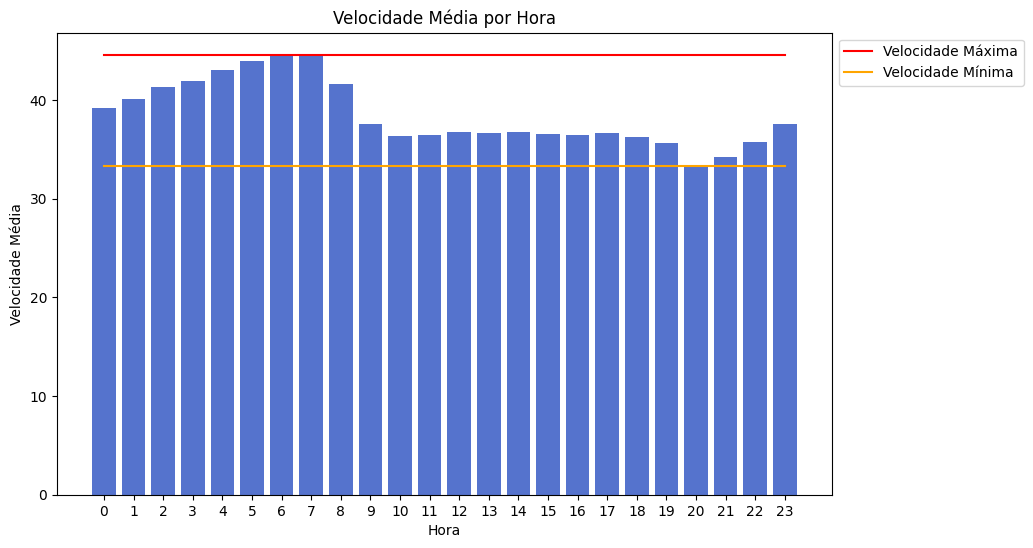

In [24]:
# Criando novo dataframe agrupando a média da velocidade por hora
df_grouped = df.groupby('hora')['velocidade'].mean().reset_index()
horas = df_grouped['hora']
max_velocidade = df_grouped['velocidade'].max()
min_velocidade = df_grouped['velocidade'].min()

# Gráfico de Velocidade Média por Hora
plt.figure(figsize=(10, 6))
sns.barplot(x=df_grouped['hora'], y=df_grouped['velocidade'], color='royalblue')
sns.lineplot(x=horas, y=[max_velocidade]*len(horas), color='r', label='Velocidade Máxima')
sns.lineplot(x=horas, y=[min_velocidade]*len(horas), color='orange', label='Velocidade Mínima')
plt.title('Velocidade Média por Hora')
plt.xlabel('Hora')
plt.ylabel('Velocidade Média')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

Neste gráfico podemos visualizar as empresas de radar que mais apresentam registros

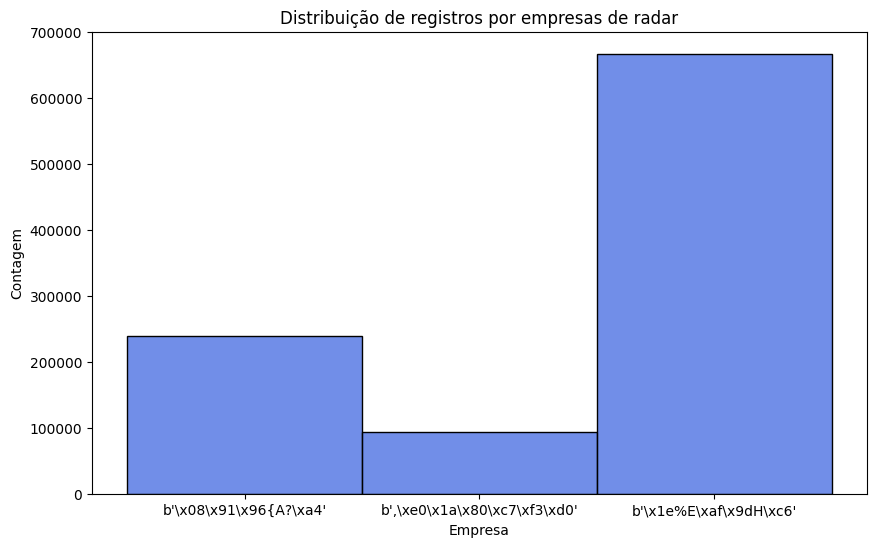

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df['empresa'], color='royalblue')
plt.title('Distribuição de registros por empresas de radar')
plt.xlabel('Empresa')
plt.ylabel('Contagem')
plt.show()

Este plot possui 4 gráficos para analisarmos os tipos de veículos e suas velocidades.\
1. O gráfico 1 indica a distribuição de tipos de veículos;
2. O gráfico 2 apresenta um gráfico violíno das velocidades, podemos ver que apesar de existirem registros bem dispersos, indo de 0 a 250, a maioria dos registros está por volta de 40;
3. O gráfico 3 ja mostra um gráfico violíno das velocidades de cada um dos tipos de veículos, mostrando que as maiores velocidades são do tipo representado pela cor vermelha;
4. Por fim, o gráfico 4 é uma representação da média de velocidade para cada um dos tipos de veículos.


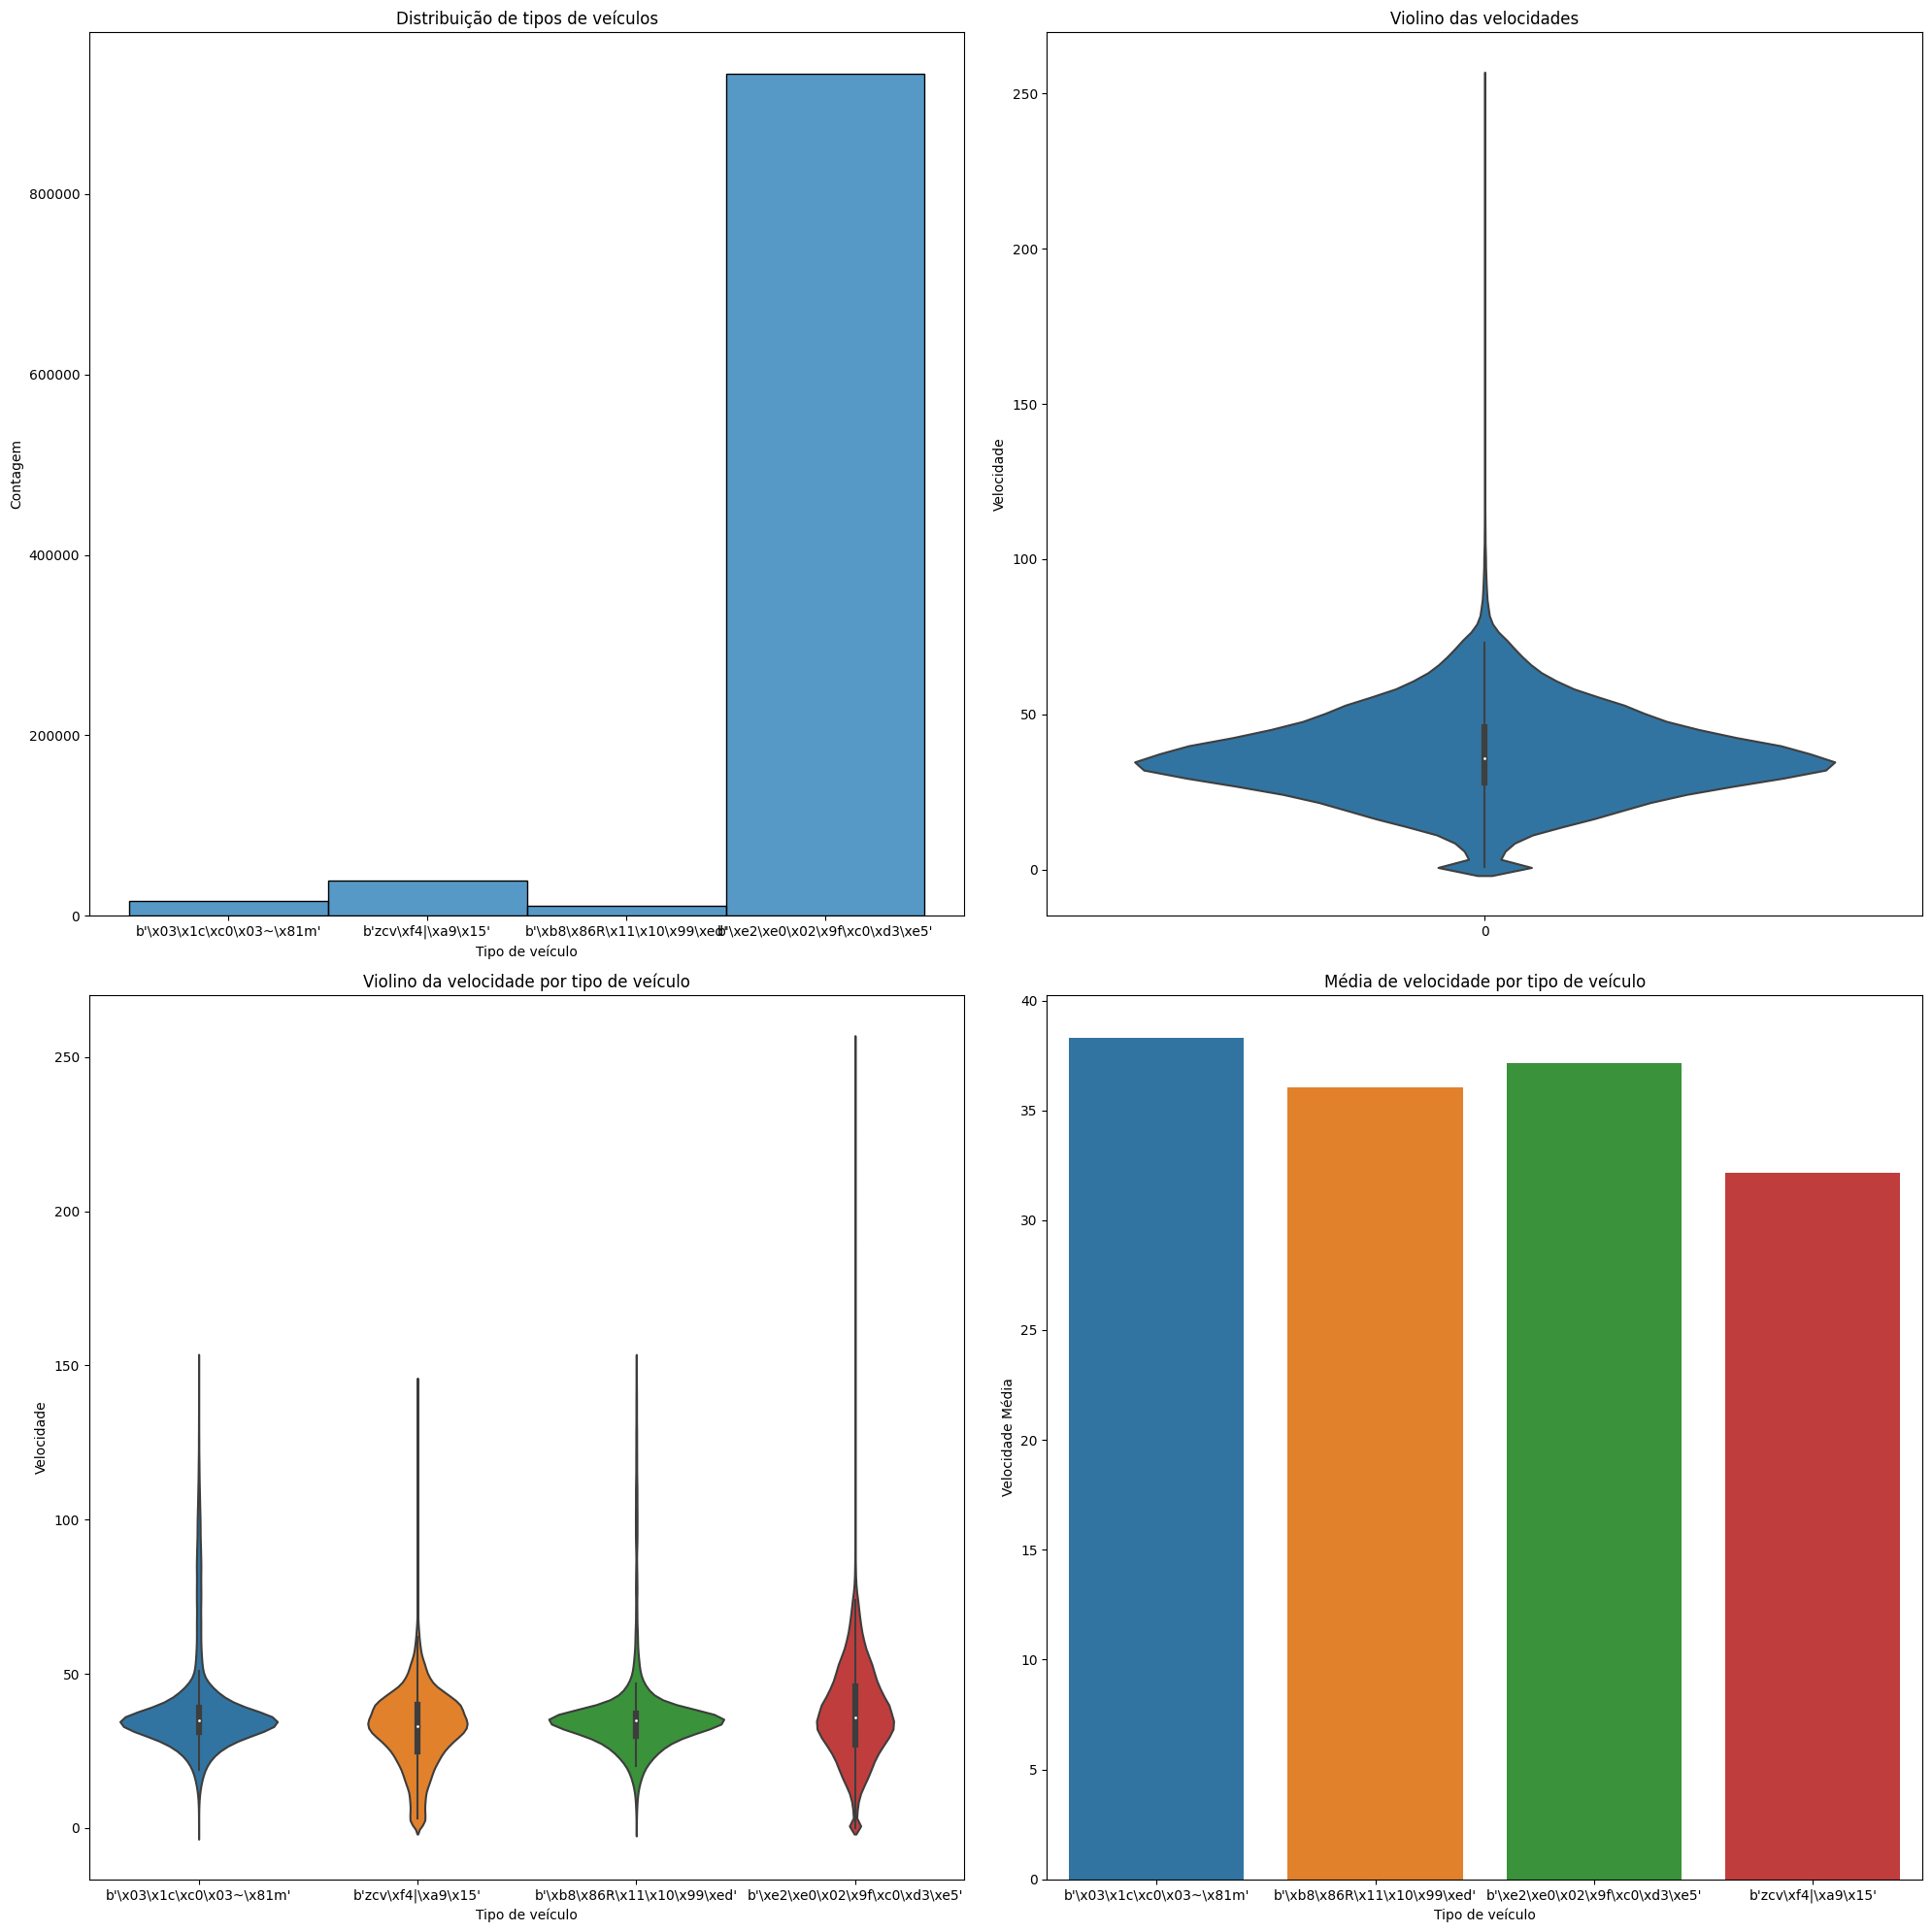

In [26]:
# Criando df para velocidade média de tipo de veículo
df_tipo_vel = df.groupby('tipoveiculo')['velocidade'].mean().reset_index()

# Criando a figura e os subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Gráfico 1: Distribuição de tipos de veículos
sns.histplot(df['tipoveiculo'], ax=axes[0, 0])
axes[0, 0].set_title('Distribuição de tipos de veículos')
axes[0, 0].set_xlabel('Tipo de veículo')
axes[0, 0].set_ylabel('Contagem')

# Definindo rótulos do eixo x para o primeiro gráfico
labels_1 = df['tipoveiculo'].unique()
axes[0, 0].set_xticks(range(len(labels_1)))
axes[0, 0].set_xticklabels(labels_1, rotation=0)

# Gráfico 2: Violino das velocidades
sns.violinplot(data=df['velocidade'], ax=axes[0, 1])
axes[0, 1].set_title('Violino das velocidades')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Velocidade')

# Gráfico 3: Violino da velocidade por tipo de veículo
sns.violinplot(data=df, x='tipoveiculo', y='velocidade', ax=axes[1, 0])
axes[1, 0].set_title('Violino da velocidade por tipo de veículo')
axes[1, 0].set_xlabel('Tipo de veículo')
axes[1, 0].set_ylabel('Velocidade')

# Gráfico 4: Média de velocidade por tipo de veículo
sns.barplot(data=df_tipo_vel, x='tipoveiculo', y='velocidade', ax=axes[1, 1])
axes[1, 1].set_title('Média de velocidade por tipo de veículo')
axes[1, 1].set_xlabel('Tipo de veículo')
axes[1, 1].set_ylabel('Velocidade Média')

# Ajustando o layout
plt.tight_layout()
plt.show()

### Placas clonadas

1. A query criada para identificar possiveis placas clonadas (ver terceira celula de código) seleciona as placas que foram identificadas por radares diferentes em um período menor que 30 minutos. 
2. Adicionalmente poderiam ser feitas operações que identifiquem a distancia entre os radares que identificaram a mesma placa, fazendo assim a análise ficar mais profunda e precisa.

In [27]:
# Confirmando que todas as colunas do dataframe atendem as caracteristicas da query
assert cloned_df[(cloned_df['placa'] == cloned_df['placa_1']) & \
    (cloned_df['camera_numero'] != cloned_df['camera_numero_1'])]\
    .shape[0] == cloned_df.shape[0]

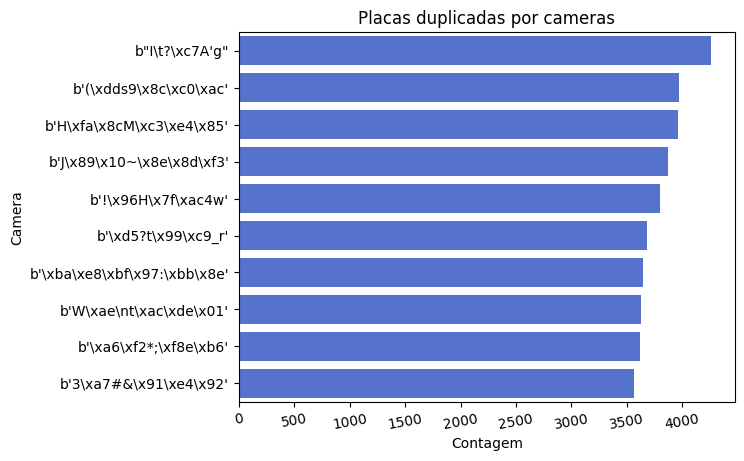

In [28]:
# Criando dataframe para contagem de Placas duplicadas identificada por cada uma das cameras
top_10_cameras = cloned_df.groupby('camera_numero')['placa'].count().reset_index()\
    .sort_values(by='placa', ascending=False).head(10)\
    .rename(columns={
        'camera_numero' : 'Camera',
        'placa': 'Contagem'
        })

# Plotando gráfico
sns.barplot(data=top_10_cameras, x='Contagem', y='Camera', color='royalblue')
plt.title(label="Placas duplicadas por cameras")
plt.xticks(rotation=10)
plt.show()